In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

## 1) Dataset

In [2]:
#Load from CSV
train_dataset = pd.read_csv('regression_dataset/train_data.csv').values
test_dataset = pd.read_csv('regression_dataset/test_data.csv').values

#Prepare X_train, y_train, X_test, y_test
X_train=train_dataset[:,0]
y_train=train_dataset[:,1]

X_test=test_dataset[:,0]
y_test=test_dataset[:,1]

#convert to Pytorch tensor
X_train=np.expand_dims(X_train, axis=1)
y_train=np.expand_dims(y_train, axis=1)
X_train=torch.from_numpy(X_train).float()
y_train=torch.from_numpy(y_train).float()

X_test=np.expand_dims(X_test, axis=1)
y_test=np.expand_dims(y_test, axis=1)
X_test=torch.from_numpy(X_test).float()
y_test=torch.from_numpy(y_test).float()

print(X_train.size())
print(min(X_train),max(X_train))
print(min(y_train),max(y_train))
print(X_test.size())
print(min(X_test),max(X_test))
print(min(y_test),max(y_test))

torch.Size([100, 1])
tensor([-4.9159]) tensor([4.9775])
tensor([-3.7430]) tensor([7.1993])
torch.Size([100, 1])
tensor([-4.9999]) tensor([4.8949])
tensor([-2.9999]) tensor([6.3360])


## 2) Models

In [14]:
class BasicRegNet(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.out = nn.Linear(in_features=Nh2, out_features=No)
        self.sig = nn.Sigmoid()
        self.relu= nn.ReLU()
        
        self.name="BasicRegNet"

        print('Network initialized')
        
    def forward(self, x, additional_out=False):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.out(x)  # Non activaction function on last layer because the output can be greater than 1
        return x

## 3) Training

### 3.1) Initialization

In [15]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

# Define the loss function
loss_function = nn.MSELoss()


from skorch.callbacks import EarlyStopping

my_early = EarlyStopping(
    monitor='valid_loss',
    patience=500,
    threshold=0.0001,
    threshold_mode='rel',
    lower_is_better=True)


from skorch import NeuralNetRegressor

net = NeuralNetRegressor(
    module=BasicRegNet,
    module__Ni= 1,
    module__Nh1 = 32,
    module__Nh2 = 32,
    module__No = 1,
    max_epochs=3000,
    
    device=device,  # uncomment this to train with CUDA
    optimizer = optim.Adam,
    optimizer__lr=0.001,
    optimizer__weight_decay=1e-5, #L2 norm
    criterion=nn.MSELoss,
    callbacks = [my_early],
    verbose=0
)

Training device: cuda


### 3.2) Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    'module__Nh1': [8,16,32,48],
    'module__Nh2': [8,16,32,48],
    'max_epochs': [1500],
    'optimizer__lr':[0.1, 0.01, 0.001],
    'optimizer__weight_decay':[1e-3,1e-4,1e-5] #L2 norm,
}
params = {
    'module__Nh1': [8,48],
    'module__Nh2': [8,48],
    'max_epochs': [1500],
    'optimizer__lr':[0.01, 0.001],
    'optimizer__weight_decay':[1e-4,1e-5] #L2 norm,
}
gs = GridSearchCV(net, params, refit=True, cv=3, scoring="neg_mean_squared_error",verbose=10)

gs.fit(X_train, y_train)

print(gs.best_score_, gs.best_params_)

In [ ]:
net=gs.best_estimator_

### 3.3) Normal Training

In [16]:
net.fit(X_train, y_train)

Network initialized


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=BasicRegNet(
    (fc1): Linear(in_features=1, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=32, bias=True)
    (out): Linear(in_features=32, out_features=1, bias=True)
    (sig): Sigmoid()
    (relu): ReLU()
  ),
)

### 3.4) Plot Losses

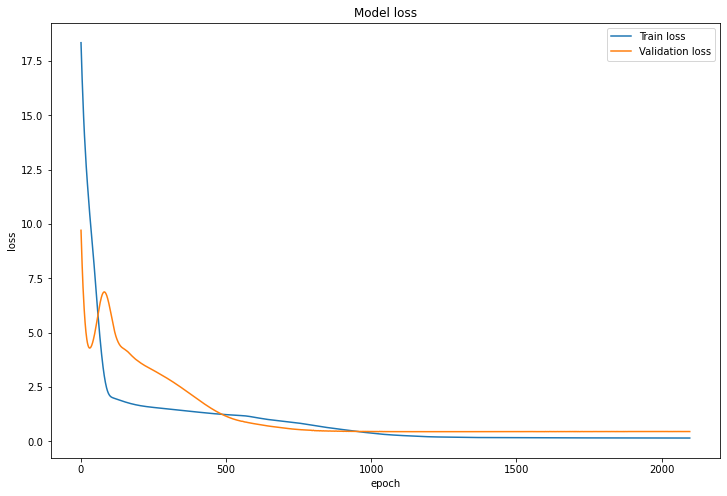

In [17]:
import datetime
save_name="Regression_"+datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")

# get train losses from all epochs, a list of floats
history = net.history
train_loss_log=history[:, 'train_loss']
val_loss_log=history[:, 'valid_loss']

# Plot losses
plt.figure(figsize=(12,8))
plt.plot(train_loss_log)
plt.plot(val_loss_log)
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train loss', 'Validation loss'], loc='upper right')
plt.savefig("models/"+save_name+"_Losses", dpi=400)
plt.show()

## 4) Test the model

In [18]:
y_pred = net.predict(X_test)
y_pred = torch.from_numpy(y_pred).float()

test_loss = loss_function(y_pred, y_test)
print(f"TEST LOSS: {test_loss}")

TEST LOSS: 0.11036255955696106


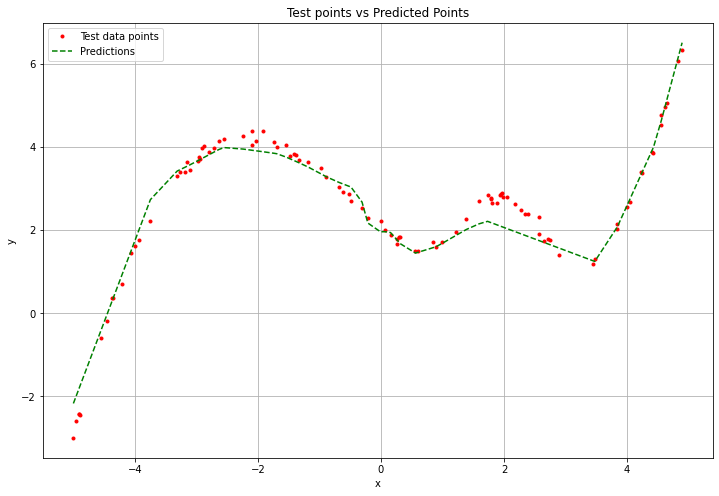

In [19]:
#Plot Test points vs Prdicted points
zipped_lists = zip(X_test, y_pred)
sorted_pairs = sorted(zipped_lists)

tuples = zip(*sorted_pairs)
X, y = [ list(tuple) for tuple in  tuples]

plt.figure(figsize=(12,8))
plt.plot(X_test, y_test, color='r', ls='', marker='.')
plt.plot(X, y, color='g', ls='--')
plt.title('Test points vs Predicted Points')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend(['Test data points', 'Predictions'], loc='upper left')
plt.savefig("models/"+save_name+"_Predictions", dpi=400)
plt.show()


## 5) Metrics Summary

In [20]:
#Train Loss
train_loss=train_loss_log[-1]

#Val loss
val_loss=val_loss_log[-1]

print("Train Loss:\t",round(train_loss,3))
print("Val Loss:\t",round(val_loss,3))
print("Test Loss:\t",round(float(test_loss),3))

Train Loss:	 0.159
Val Loss:	 0.457
Test Loss:	 0.11


## 6) Save model

In [21]:
#Saving the whole model
import pickle
with open("models/"+save_name+".pkl", 'wb') as f:
    pickle.dump(net, f)
    
#Load the model
#with open(file_name, 'rb') as f:
#    new_net = pickle.load(f)

#Save Metrics to File
f = open("models/"+save_name+"_Metrics.txt", "a")
f.write('Train loss:\t'+ str(round(train_loss,3))+ "\n")
f.write('Val loss:\t'+ str(round(val_loss,3))+ "\n")
f.write('Test loss:\t'+ str(round(float(test_loss),3))+ "\n")
f.close()

## 7) Network Analysis

### 7.1) Weights histogram

In [22]:
#Access network parameters
my_best_net = net.module_

#First hidden Layer
h1_w = my_best_net.fc1.weight.data.cpu().numpy()
h1_b = my_best_net.fc1.bias.data.cpu().numpy()

#Second hidden Layer
h2_w = my_best_net.fc2.weight.data.cpu().numpy()
h2_b = my_best_net.fc2.bias.data.cpu().numpy()

# Output layer
out_w = my_best_net.out.weight.data.cpu().numpy()
out_b = my_best_net.out.bias.data.cpu().numpy()


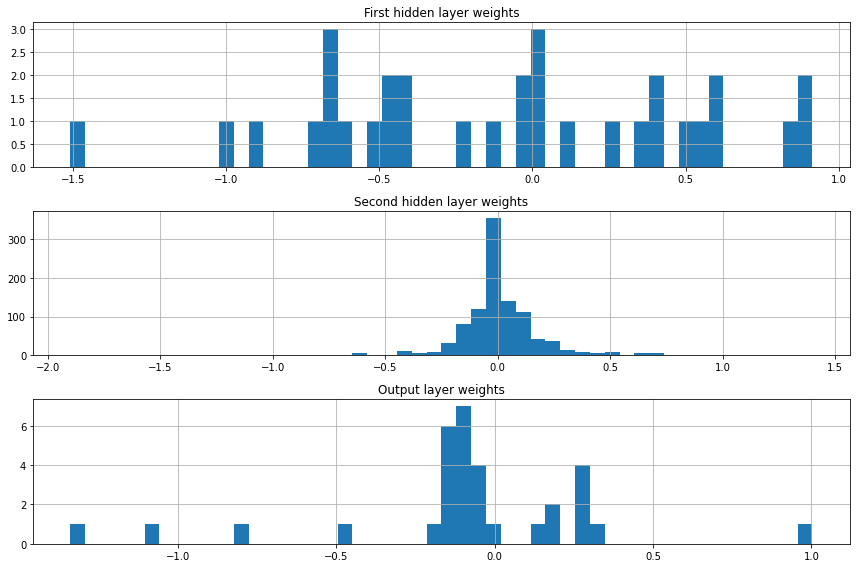

In [23]:
# Weights histogram
fig, axs = plt.subplots(3, 1, figsize=(12,8))
axs[0].hist(h1_w.flatten(), 50)
axs[0].set_title('First hidden layer weights')
axs[1].hist(h2_w.flatten(), 50)
axs[1].set_title('Second hidden layer weights')
axs[2].hist(out_w.flatten(), 50)
axs[2].set_title('Output layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.savefig("models/"+save_name+"_Weights-histogram", dpi=400)
plt.show()

### 7.2) Analyze activations

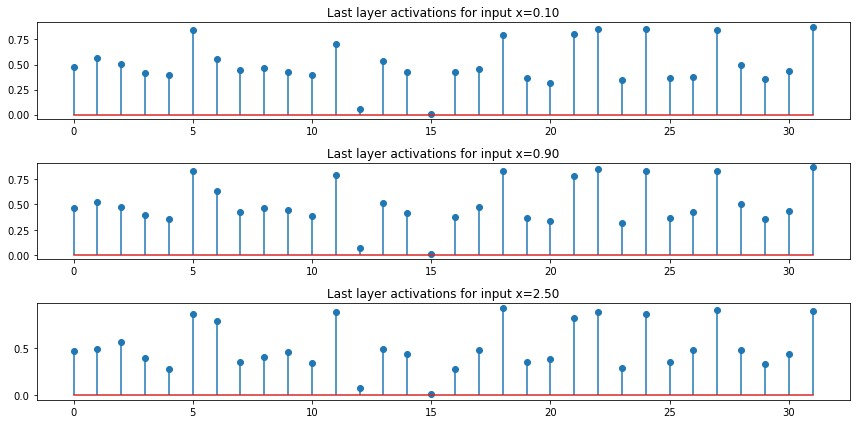

In [24]:
def get_activation(layer, input, output):
    global activation
    activation = torch.sigmoid(output)
    
### Register hook
net=my_best_net
hook_handle = net.fc2.register_forward_hook(get_activation)

### Analyze activations
net = net.to(device)
net.eval()
with torch.no_grad():
    x1 = torch.tensor([0.1]).float().to(device)
    y1 = net(x1)
    z1 = activation
    x2 = torch.tensor([0.9]).float().to(device)
    y2 = net(x2)
    z2 = activation
    x3 = torch.tensor([2.5]).float().to(device)
    y3 = net(x3)
    z3 = activation

### Remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(12,6))
axs[0].stem(z1.cpu().numpy(), use_line_collection=True)
axs[0].set_title('Last layer activations for input x=%.2f' % x1)
axs[1].stem(z2.cpu().numpy(), use_line_collection=True)
axs[1].set_title('Last layer activations for input x=%.2f' % x2)
axs[2].stem(z3.cpu().numpy(), use_line_collection=True)
axs[2].set_title('Last layer activations for input x=%.2f' % x3)
plt.tight_layout()
plt.savefig("models/"+save_name+"_Activations", dpi=400)
plt.show()